In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time
from math import exp
from tqdm import tqdm

from neuralnet.mlp import MLP, AntisymmetricMLP
from neuralnet.resnet import ResNet, PowerSkipResNet

from rbm.rbm import RBM
from rbm.adjacency import get_adjacency_matrices
from rbm.coupling import get_coupling_matrix
from rbm.configurations import get_configurations
from rbm.loss import contrastive_divergence, kl_divergence

from utils.newton import find_root
from utils.samplers import HMC
from utils.grad import batch_grad, grad, jacobian
from utils import plots

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cpu')

# Models

In [3]:
lattice = 'lieb'
representation = 'a1'

lieb_square, lieb_cross = get_adjacency_matrices(lattice)
coupling_matrix = get_coupling_matrix(representation)

n_couplers = coupling_matrix.size(0)

In [4]:
flow = MLP(
    in_dim=n_couplers, 
    out_dim=n_couplers, 
    hidden_depth=n_couplers, 
    width=16 * n_couplers, 
    device=device
)

sum(p.numel() for p in flow.parameters() if p.requires_grad)

321

In [5]:
fine = RBM(lieb_square, coupling_matrix, device=device)
coarse = RBM(lieb_cross, coupling_matrix, device=device)

In [6]:
sampler = HMC(device=device)

# Training

In [7]:
epoch = 0
epochs = 4096
anneal_at = 1024
n_models = 32 * (3 ** n_couplers)
n_cd_samples = 256
k_fine = 16
k_coarse = 1

In [8]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
roots = []

J = torch.randn(n_models, n_couplers, device=device)

In [9]:
beta = lambda epoch : 32/(1 + exp( -16 * (epoch - anneal_at) / epochs ))

In [10]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : beta(epoch) * (flow(J) ** 2).sum(dim=-1)

    # RG Flow
    J = sampler.step(J).detach()

    fine.J = J
    coarse.J = J + flow(J)

    # Loss
    loss = contrastive_divergence(
        fine, coarse, 
        batch_size=n_cd_samples, 
        k_fine=k_fine, 
        k_coarse=k_coarse
    )
    #loss = kl_divergence(fine, coarse)
    loss.backward()
    optimizer.step()

    Js.append(J.cpu().detach())
    losses.append(float(loss))

    if epoch >= 2048:
        if n_couplers == 1:
            x = torch.tensor([0.8], device=device)
        elif n_couplers == 5:
            x = torch.tensor([0.8, 0., 0., 0.8, 0.8], device=device)
        
        root = find_root(flow, x)
        if torch.all(torch.logical_and(root > -4, root < 4)): 
            roots.append(root.cpu().detach())
        else:
            roots.append(torch.empty_like(root).fill_(float('nan')).cpu())

100%|███████████████████████████████████████| 4096/4096 [03:24<00:00, 20.06it/s]


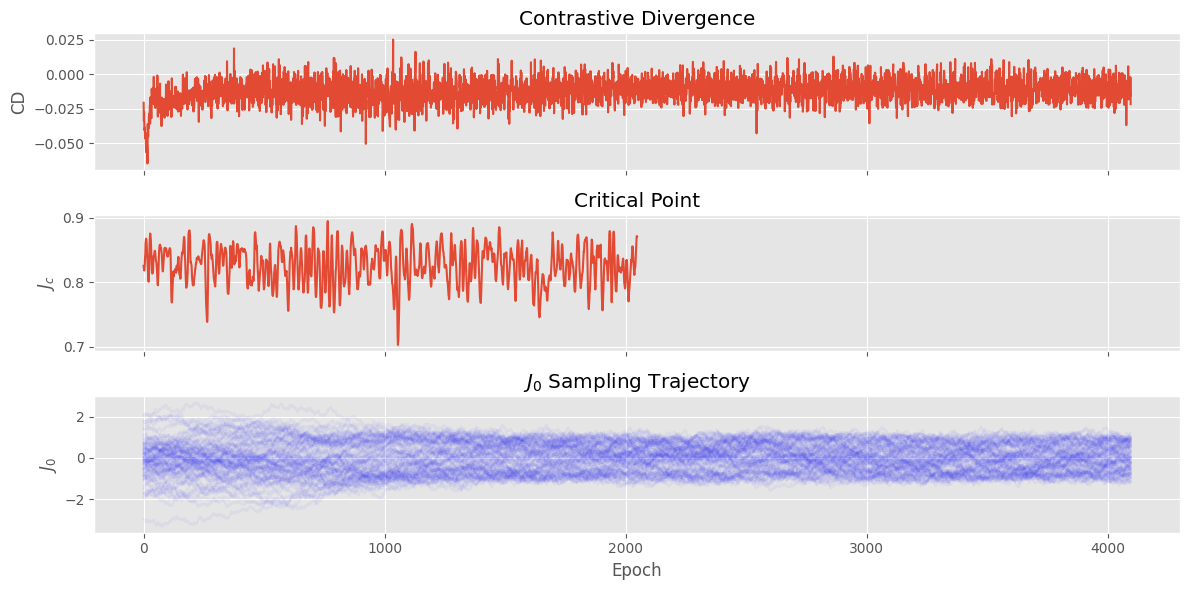

In [11]:
fig, axs = plt.subplots(n_couplers + 2, 1, figsize=(12, n_couplers * 2 + 4), sharex=True)

axs[0].plot(losses)
axs[0].set_ylabel('CD')
axs[0].set_title('Contrastive Divergence')

if len(roots) != 0:
    roots_tensor = torch.stack(roots)
    axs[1].plot(roots_tensor[:, 0])
    axs[1].set_ylabel(r'$J_c$')
    axs[1].set_title('Critical Point')

for traj in torch.stack(Js, dim=2):
    for i in range(2, n_couplers+2):
        axs[i].plot(traj[i-2].cpu().detach(), alpha=4/n_models, c='blue')
        axs[i].set_ylabel(rf'$J_{i-2}$')
        axs[i].set_title(rf'$J_{i-2}$ Sampling Trajectory')

axs[-1].set_xlabel('Epoch')

plt.tight_layout()

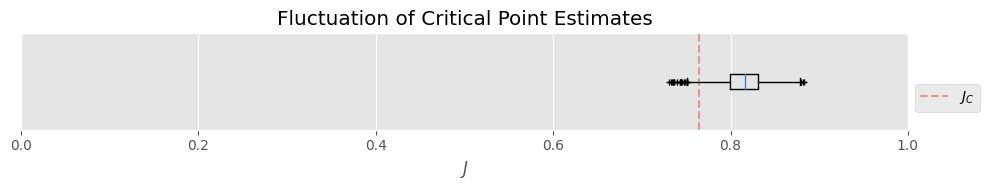

In [19]:
data = [
    #torch.load('data/a1e_cd_critical_points_2048.pt')[:, 0], 
    #torch.load('data/a1_kl_critical_points_4096.pt')[2048:, 0], 
    torch.load('data/a1_cd_critical_points_4096.pt')[2048:, 0], 
    #roots_tensor[~torch.any(roots_tensor.isnan(),dim=1)][:, 0]
]

labels = [
    #r'$A_1 \oplus E$', 
    #'Kullback-Liebler', 
    #r'$A_1$', 
    #'Contrastive'
    ''
]

fig, ax = plots.boxplots(data, labels)

ax.set_xlim(0, 1)
ax.set_title('Fluctuation of Critical Point Estimates')
ax.set_xlabel(r'$J$')

fig.tight_layout()
fig.savefig('figures/a1_critical_points_boxplot.png')

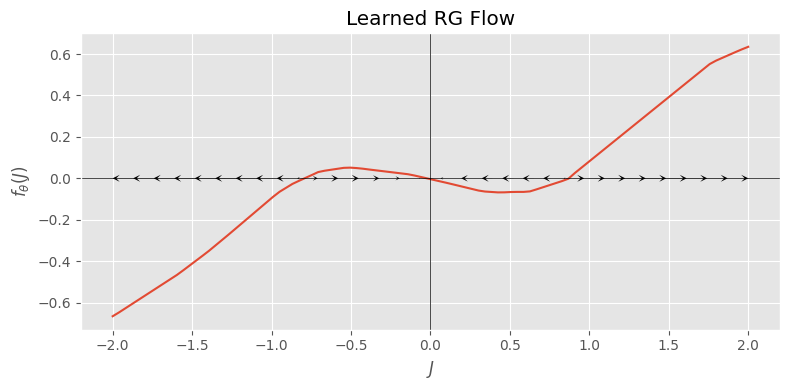

In [15]:
flow.eval()

if n_couplers == 1:
    xlim = (-2, 2)
    
    fig, ax = plots.plot1d(flow, xlim=xlim, device=device)
    
    ax.set_ylabel(r'$f_{\theta}(J)$')
    ax.set_xlabel(r'$J$')
    ax.set_title(r'Learned RG Flow')
    

    x = torch.linspace(*xlim, 32, device=device).unsqueeze(1)
    fx = flow(x).cpu().detach()
    x = x.cpu()
    ax.quiver(x, torch.zeros_like(x), fx, torch.zeros_like(fx), pivot='tip', width=0.0001, headwidth=100, headlength=100, headaxislength=50, color='black')

else:
    fig, axs = plots.nd_flows(
        flow, 
        lambda grid: -torch.log(sampler.potential(grid)), 
        n_couplers, 
        xlim=(-1.5, 1.5), 
        ylim=(-1.5, 1.5), 
        res=128
    )

    fig.suptitle(r'Flows and $- \log || f_{\theta} ||$ on the Coordinate Planes', size=24)

fig.tight_layout()

#fig.savefig(f'figures/{representation}_flows.png')

In [14]:
x, y = torch.meshgrid(
    torch.linspace(0, 1.5, 100, requires_grad=False), 
    torch.linspace(-0.3, 0.3, 100, requires_grad=False), 
    indexing='xy'
)

grid = torch.stack((x, y), dim=2).to(device)

mapping = torch.tensor(
    [[1, 0, 0, 0, 0],
     [0, 1, 1, 1, 1]], 
    device=device
)

flow_grid = (flow(grid @ mapping) @ mapping.t()).cpu().detach()

plt.streamplot(
    x.numpy(), y.numpy(), 
    flow_grid[:, :, 0], flow_grid[:, :, 1], 
    density=2, 
    linewidth=0.5, 
    color='black'
)

RuntimeError: expected m1 and m2 to have the same dtype, but got: float != long long

In [ ]:
roots_dict = {
    'Number of HMC trajectories' : torch.load('./data/hyperparameter_tuning_1/n_models/roots.pt', map_location=torch.device('cpu')), 
    'Number of Contrastive Divergence Samples' : torch.load('./data/hyperparameter_tuning_1/n_cd_samples/roots.pt', map_location=torch.device('cpu')), 
    'Number of Fine-Grain Model Gibbs Steps' : torch.load('./data/hyperparameter_tuning_1/k_fine/roots.pt', map_location=torch.device('cpu')), 
    'Number of Coarse-Grain Model Gibbs Steps' : torch.load('./data/hyperparameter_tuning_1/k_coarse/roots.pt', map_location=torch.device('cpu')), 
}

values_dict = {
    'Number of HMC trajectories' : torch.load('./data/hyperparameter_tuning_1/n_models/values.pt', map_location=torch.device('cpu')), 
    'Number of Contrastive Divergence Samples' : torch.load('./data/hyperparameter_tuning_1/n_cd_samples/values.pt', map_location=torch.device('cpu')), 
    'Number of Fine-Grain Model Gibbs Steps' : torch.load('./data/hyperparameter_tuning_1/k_fine/values.pt', map_location=torch.device('cpu')), 
    'Number of Coarse-Grain Model Gibbs Steps' : torch.load('./data/hyperparameter_tuning_1/k_coarse/values.pt', map_location=torch.device('cpu')), 
}

fig, axs = plt.subplots(len(roots_dict), 1, figsize=(len(roots_dict) * 2, 8))

for i, (roots, (value_name, values)) in enumerate(zip(roots_dict.values(), values_dict.items())):
    
    
    if i == 0:
        roots = roots[1:]
        values = values[1:]

    
    means = roots.nanmean(axis=1)
    stds = torch.tensor([
        run[~run.isnan()].std() for run in roots
    ])
    
    axs[i].set_ylim(-0.5, 1.5)
    axs[i].axhline(0.7643, color='grey', linestyle='dashed', alpha=0.5)

    axs[i].plot(values, means)
    axs[i].fill_between(values, means - stds, means + stds, alpha=0.5)
    axs[i].set_xlabel(value_name)
    
fig.suptitle('Means and Standard Deviations of Critical Point Estimates from Varying Hyperparameters')
fig.tight_layout()

In [ ]:
fig.savefig('figures/hyperparameter_tuning_1.png')

In [ ]:
roots = roots_dict['Number of Contrastive Divergence Samples']

In [ ]:
means = roots.nanmean(axis=1)
stds = torch.tensor([
    run[~run.isnan()].std() for run in roots
])

In [ ]:
plt.plot(means - 0.7643)